# The Fokas transform pair

* Course: YSC4103 MCS Capstone
* Date created: 2018/10/07
* Name: Linfan XIAO
* Description: Implement the transform pair (2.15a), (2.15b) on page 10 of "Evolution PDEs and augmented eigenfunctions. Finite interval."

Transform pair:
\begin{alignat*}{2}
F_\lambda: f(x)&\mapsto F(\lambda):\quad F_\lambda(f) &= 
\begin{cases}
F_\lambda^+(f),&\quad\mbox{if $\lambda\in \Gamma_0^+\cup \Gamma_a^+$}\\
F_\lambda^-(f),&\quad\mbox{if $\lambda\in \Gamma_0^-\cup \Gamma_a^-$}\\
\end{cases}\\
f_x: F(\lambda)&\mapsto f(x):\quad f_x(F) &= \int_\Gamma e^{i\lambda x}F(\lambda)\,d\lambda,\quad x\in [0,1].
\end{alignat*}

## Importing packages and modules

In [16]:
using NBInclude
using SymPy
using QuadGK
import QuadGK.quadgk
# using HCubature
using ApproxFun
using Roots
using Gadfly
using PyPlot
pygui(true)
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\construct_adjoint.jl")
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\construct_adjoint_unit_tests.jl")
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\approximate_roots_of_exponentialPolynomial.jl")
# @nbinclude("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\approximate_roots_of_exponentialPolynomial.ipynb")

approximate_zero (generic function with 1 method)

## Global variables

In [2]:
lambda = symbols("lambda")

# declare x, y as real variables
x = symbols("x", real = true)
y = symbols("y", real = true)

sympyAddExpr = 1 + x
sympyMultExpr = 2*x
sympyPowerExpr = x^2
sympyExpExpr = e^x

infty = 5
tol = 1e-5
signif = 3 # Should this agree with the tolerance level? Distinguish between printing and calculation

3

## Helper functions

### `assign`

In [3]:
# Assign string as variable name
function assign(s::AbstractString, v::Any)
    s=Symbol(s)
    @eval (($s) = ($v))
end

assign (generic function with 1 method)

### `add_func`

In [4]:
# Function addition (f + g)(x) := f(x) + g(x)
function add_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f + g
            else
                return f + g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) + g
            else
                return f(x) + g(x)
            end
        end
    end
    return h
end

add_func (generic function with 1 method)

### `mult_func`

In [5]:
# Function multiplication (f * g)(x) := f(x) * g(x)
function mult_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f * g
            else
                return f * g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) * g
            else
                return f(x) * g(x)
            end
        end
    end
    return h
end

mult_func (generic function with 1 method)

### `clean_up_float`

In [6]:
# function to clean up floating point numbers in (constants and coefficients of) the symbolic expression of an exponential polynomial
# helper function that deals with the case where func(expr) = func(sympyExpExpr)
# although the function body is the same as "others", this case is isolated because negative exponents, e.g., factor_list(e^(-im*x)), give PolynomialError('a polynomial expected, got exp(-I*x)',), while factor_list(cos(x)) runs normally
function clean_up_float_exp(expr::SymPy.Sym)
    term = args(expr)[1]
    termCleaned = clean_up_float_power_add_mult(term)
    result = subs(expr,args(expr)[1],termCleaned)
    return result
end
# helper function that deals with the case where func(expr) = func(sympyPowerExpr)
function clean_up_float_power(expr::SymPy.Sym)
    power = terms[2]
    # powerCleaned = round(power, signif) # floating point powers may cause cleaned numbers to become dirty again for imaginary numbers, e.g., 0.124*I^(1.0) evaluates to 0.12399847344634*I
    powerCleaned = power # assume integer powers, which should be true for exponential polynomials
    result = terms[1]^powerCleaned
    return result
end
# helper function that deals with the case where func(expr) = func(sympyMultExpr)
function clean_up_float_mult(expr::SymPy.Sym)
    terms = args(expr)
    result = 1
    # if the expanded expression contains toplevel multiplication, the individual terms must all be powers
    for term in terms
        # if term is exponential
        if func(term) == func(sympyExpExpr)
            termCleaned = clean_up_float_exp(term)
        # else, further split each product term into indivdual factors
        else
           (constant, factors) = factor_list(term)
            constantCleaned = round(constant, signif)
            termCleaned = constantCleaned
            for (factor, power) in factors
                powerCleaned = power
                factorCleaned = factor^powerCleaned
                termCleaned = termCleaned * factorCleaned
            end 
        end
        result = result * termCleaned
    end
    return result
end
# helper function that deals with the case where func(expr) = func(sympyAddExpr)
function clean_up_float_add(expr::SymPy.Sym)
    terms = args(expr)
    result = 0
    for term in terms
        # if term is exponential
        if func(term) == func(sympyExpExpr)
            termCleaned = clean_up_float_exp(term)
        # else, further split each product term into indivdual factors
        else #if func(term) = func(sympyMultExpr)
            termCleaned = clean_up_float_mult(term)
        end
        result = result + termCleaned
    end
    return result
end
# helper function that deals with the cases where func(expr) = func(sympyPowerExpr), func(sympyAddExpr), func(sympyMultExpr)
function clean_up_float_power_add_mult(expr::SymPy.Sym)
    term = expr
    if func(term) == func(sympyPowerExpr)
        termCleaned = clean_up_float_power(term)
    elseif func(term) == func(sympyAddExpr)
        termCleaned = clean_up_float_add(term)
    else # if func(term) == func(sympyMultExpr)
        termCleaned = clean_up_float_mult(term)
    end
    return termCleaned
end
# helper function that deals with the case where func(expr) != func(sympyPowerExpr), func(sympyAddExpr), func(sympyMultExpr)
function clean_up_float_others(expr::SymPy.Sym)
    # if the expanded expression is neither of the above, it must be a single term, e.g., x or cos(2x+1), which is a function wrapping around an expression; in this case, use the helper function to clean up the expression and feed it back to the function
    term = args(expr)[1]
    termCleaned = clean_up_float_power_add_mult(term)
    result = subs(expr,args(expr)[1],termCleaned)
    return result
end

# main function
function clean_up_float(expr::SymPy.Sym)
    expr = expand(expr)
    if func(expr) == func(sympyPowerExpr)
#         println(expr)
#         println("power!")
        result = clean_up_float_power(expr)
#         println("result = $result")
    elseif func(expr) == func(sympyAddExpr)
#         println(expr)
#         println("addition!")
        result = clean_up_float_add(expr)
#         println("result = $result")
    elseif func(expr) == func(sympyMultExpr)
#         println(expr)
#         println("multiplication!")
        result = clean_up_float_mult(expr)
#         println("result = $result")
    else
        # println(expr)
        # println("single term!")
        result = clean_up_float_others(expr)
        # println("result = $result")
    end
    return result
end

clean_up_float (generic function with 1 method)

In [7]:
expr = 1+5.02*exp(-1.0*im*lambda) # factor_list(expr) gives PolynomialError('a polynomial expected, got exp(-I*x)',)
# expr = 4.33*cos(-1.0*lambda)
func(expr)
args(expr)
# term = exp(-1.0*im*lambda)
# func(term)
# clean_up_float_exp(term)
clean_up_float(expr)

          -1.0*I*lambda
1 + 5.02*e             

### `isApproxLess`

In [8]:
function isApproxLess(x::Number, y::Number; atol = 1e-10)
    return !isapprox(x,y; atol = atol) && x < y
end

isApproxLess (generic function with 1 method)

### `isApprox`

In [9]:
function isApprox(x::Number, y::Number; atol = 1e-10)
    return isapprox(x, y; atol = atol)
end

isApprox (generic function with 1 method)

### `argument`

In [10]:
# Find the argument of a complex number in [0,2pi)
function argument(z::Number)
    if angle(z) >= 0 # in [0,pi]
        return angle(z)
    else # Shift from (-pi, 0] to [pi,2pi)
        argument = 2pi + angle(z) # This is in (pi,2pi]
        if isApprox(argument, 2pi) # Change to [pi,2pi)
            return 0
        else
            return argument
        end
    end
end

argument (generic function with 1 method)

### `contour_tracing`

In [11]:
# Plot the contour sectors by sampling points
function contour_tracing(a::Number, n::Int, infty::Number, sampleSize::Int)
    lambdaVec = []
    for counter = 1:sampleSize
        x = rand(Uniform(-infty,infty), 1, 1)[1]
        y = rand(Uniform(-infty,infty), 1, 1)[1]
        lambda = x + y*im
        if real(a*lambda^n)>0
            append!(lambdaVec, lambda)
        end
    end
    plot(x=real(lambdaVec), y=imag(lambdaVec), Guide.xlabel("Re"), Guide.ylabel("Im"), Coord.Cartesian(ymin=-infty,ymax=infty, xmin=-infty, xmax=infty, fixed = true))
end

contour_tracing (generic function with 1 method)

### `find_distancePointLine`

In [12]:
# Find distance between a complex number and a line (given by an angle in [0,2pi)
function find_distancePointLine(z::Number, theta::Number)
    if theta >= 2pi && theta < 0
        throw(error("Theta must be in [0,2pi)"))
    else
        if isApprox(argument(z), theta)
            return 0
        else
            x0, y0 = real(z), imag(z)
            if isApprox(theta, pi/2) || isApprox(theta, 3pi/2)
                return abs(x0)
            elseif isApprox(theta, 0) || isApprox(theta, 2pi)
                return abs(y0)
            else
                k = tan(theta)
                x = (y0+1/k*x0)/(k+1/k)
                y = k*x
                distance = norm(z-(x+im*y))
                return distance
            end
        end
    end
end

find_distancePointLine (generic function with 1 method)

## Structs

## Main functions

### `eqnWrapper`

Initial boundary-value problem: (TBD)

In [13]:
function eqnWrapper(a::Number, S::LinearDifferentialOperator, f::Function, B::VectorBoundaryForm)
    pFunctions = [mult_func(a, func) for func in S.pFunctions]
    (a,b) = (a*S.a, a*S.b)
    symPFunctions = [a*symFunc for symFunc in (S.symL).symPFunctions]
    t = (S.symL).t
    symL = SymLinearDifferentialOperator(symPFunctions, (a,b), t)
    L = LinearDifferentialOperator(pFunctions, (a,b), symL)
    U = B
    return (L, U, f)
end

eqnWrapper (generic function with 1 method)

### `get_MPlusMMinus`

In [14]:
# Get M+, M- in (2.13a), (2.13b) as functions of lambda (for fixed adjointU) as well as their symbolic expressions
function get_MPlusMinus(adjointU::VectorBoundaryForm; symbolic = false)
    # these are numeric matrices
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    alpha = e^(2pi*im/n)
    if symbolic
        # return MPlus and MMinus as symbolic expressions with (the global variable) lambda as free variable
        MPlusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumPlus = 0
                for r = 0:(n-1)
                    summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                    summandPlus = expand(summandPlus)
                    sumPlus += summandPlus
                end
                sumPlus = simplify(clean_up_float(sumPlus))
                MPlusMat[k,j] = sumPlus
            end
        end
        MPlusSym = MPlusMat
        MMinusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumMinus = 0
                for r = 0:(n-1)
                    summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                    summandMinus = expand(summandMinus)
                    sumMinus += summandMinus
                end
                sumMinus = simplify(clean_up_float(sumMinus))
                MMinusMat[k,j] = sumMinus
            end
        end
        MMinusSym = MMinusMat
        return (MPlusSym, MMinusSym)
    else
        # if not symbolic, return MPlus and MMinus as functions of lambda
        function MPlus(lambda::Number)
            MPlusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumPlus = 0
                    for r = 0:(n-1)
                        summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                        sumPlus += summandPlus
                    end
                    MPlusMat[k,j] = sumPlus
                end
            end
            return MPlusMat
        end
        function MMinus(lambda::Number)
            MMinusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumMinus = 0
                    for r = 0:(n-1)
                        summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                        sumMinus += summandMinus
                    end
                    MMinusMat[k,j] = sumMinus
                end
            end
            return MMinusMat
        end
    end
    return (MPlus, MMinus)
end

get_MPlusMinus (generic function with 1 method)

### `get_M`

In [15]:
# Get M in (2.14) as a function of lambda (for fixed adjointU) as well as its symbolic expression
function get_M(adjointU::VectorBoundaryForm; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    alpha = e^(2pi*im/n)
    if symbolic
        # return M as a symbolic expression with (the global variable) lambda as free variable
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        MLambdaSym = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                MLambdaSym[k,j] = simplify(clean_up_float(MPlusSym[k,j] + MMinusSym[k,j] * e^(-im*alpha^(k-1)*lambda)))
            end
        end
        MSym = MLambdaSym
        return MSym
    else
       function M(lambda::Number)
            (MPlus, MMinus) = get_MPlusMinus(adjointU)
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            MLambda = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    MLambda[k,j] = MPlusLambda[k,j] + MMinusLambda[k,j] * e^(-im*alpha^(k-1)*lambda)
                end
            end
            return MLambda
        end
        return M 
    end
end

get_M (generic function with 1 method)

### `get_delta`

In [16]:
# Get delta := det(M) as a function of M(lambda) (for fixed adjointU) as well as its symbolic expression
function get_delta(adjointU::VectorBoundaryForm; symbolic = false)
    if symbolic
        M = get_M(adjointU; symbolic = true)
        deltaSym = simplify(SymPy.det(M))
        return deltaSym
    else
       function delta(lambda::Number)
            M = get_M(adjointU)
            MLambda = convert(Array{Complex}, M(lambda))
            return det(MLambda)
        end
        return delta 
    end
end

get_delta (generic function with 1 method)

### `get_Xlj`

In [17]:
# Get Xlj, which is the (n-1)*(n-1) submatrix of M(lambda) whose (1,1) entry is the (l+1, j+1) entry of M(lambda), as a function of lambda (for fixed adjointU, M, l, j), as well as its symbolic expression (TBD)
function get_Xlj(adjointU::VectorBoundaryForm, M::Function, l::Number, j::Number)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    M = get_M(adjointU)
    function Xlj(lambda::Number)
        MLambda = M(lambda)
        MLambdaBlock = [MLambda MLambda; MLambda MLambda]
        XljLambda = MLambdaBlock[(l+1):(l+1+n-2), (j+1):(j+1+n-2)]
        return XljLambda
    end
    return Xlj
end

get_Xlj (generic function with 1 method)

### `get_ChebyshevIntegralSym`

Suppose that on $[0,1]$,
\begin{align*}
f(x) = \sum_{n=0}^N a_n T_n(x)
\end{align*}
is a finite sum of Chebyshev polynomials
\begin{align*}
T_n(x) = 
\begin{cases}
\cos(n\cdot \arccos(x))&\quad\mbox{$|x|\leq 1$}\\
\frac{1}{2}\left((x-\sqrt{x^2-1})^n + (x+\sqrt{x^2-1})^n\right)&\quad\mbox{|x|>1}.
\end{cases}
\end{align*}
Then
$$f(x) = \sum_{n=0}^N a_n \cos(n\cdot \arccos(x)).$$
\begin{align*}
\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx &= \int_0^1e^{-i\alpha^{l-1}\lambda x}\sum_{n=0}^N a_n \cos(n\cdot \arccos(x))\,dx\\
&= \sum_{n=0}^N a_n\int_0^1e^{-i\alpha^{l-1}\lambda x}\cos(n\cdot \arccos(x))\,dx.
\end{align*}
Writing $c=\alpha^{l-1}\lambda$, 
$$\int_0^1e^{-i\alpha^{l-1}\lambda x}\cos(n\cdot \arccos(x))\,dx = \int_0^1e^{-ic x}\cos(n\cdot \arccos(x))\,dx.$$
<!--
By Theorem 1 in "The Fourier Transforms of the Chebyshev and Legendre Polynomials", a closed formula can be found for the Fourier transform of $T_n(x)$, 
\begin{align*}
\hat{T}_n(\lambda) &= \int_{-1}^1 e^{-i\lambda x}T_n(x)\,dx\\
&= \int_{-1}^1 e^{-i\lambda x} \cos(n\cdot\arccos(x))\,dx\\
&= \int_{-1}^0 e^{-i\lambda x} \cos(n\cdot\arccos(x))\,dx + \int_0^{1} e^{-i\lambda x} \cos(n\cdot\arccos(x))\,dx.
\end{align*}
-->
Writing $x=\cos\theta$,
\begin{align*}
\int_0^1e^{-ic x}\cos(n\cdot \arccos(x))\,dx &= \int_0^1e^{-ic \cos\theta}\cos(n\cdot \arccos(\cos\theta))\,d\cos\theta\\
&= \int_{\pi/2}^0 e^{-ic \cos\theta}\cos(n\theta)(-\sin\theta)\,d\theta\\
&= \int_0^{\pi/2} e^{-ic \cos\theta}\cos(n\theta)\sin\theta\,d\theta.
\end{align*}
Define
$$\tilde{T}_n(c) := \int_0^{\pi/2} e^{-ic \cos\theta}\cos(n\theta)\sin\theta\,d\theta.$$
Then
\begin{align*}
\tilde{T}_n(0) = \int_0^{\pi/2}\cos(n\theta)\sin\theta\,d\theta &=
\begin{cases}
0&\quad\mbox{if $n=0$}\\
[\frac{1}{2}\sin^2\theta + \frac{0}{2}\cos^2\theta]_0^{\frac{\pi}{2}}&\quad\mbox{if $n=1$}\\
\left[\frac{n}{(n-1)(n+1)}\sin\theta\sin(n\theta) + \frac{1}{(n-1)(n+1)}\cos\theta\cos(n\theta)\right]_0^{\frac{\pi}{2}}&\quad\mbox{if $n\geq 2$}
\end{cases}\\
&= 
\begin{cases}
0&\quad\mbox{if $n=0$}\\
\frac{1}{2}\sin^2(\frac{\pi}{2}) - \frac{1}{2}\sin^2(0)&\quad\mbox{if $n=1$}\\
\frac{n}{n^2-1}\sin(\frac{\pi}{2})\sin(\frac{n\pi}{2}) + \frac{1}{n^2-1}\cos(\frac{\pi}{2})\cos(\frac{n\pi}{2}) - \frac{n}{n^2-1}\sin(0)\sin(0) - \frac{1}{n^2-1}\cos(0)\cos(0)&\quad\mbox{if $n\geq 2$}
\end{cases}\\
&= 
\begin{cases}
0&\quad\mbox{if $n=0$}\\
\frac{1}{2}&\quad\mbox{if $n=1$}\\
\frac{n}{n^2-1}\sin(\frac{n\pi}{2})-\frac{1}{n^2-1}&\quad\mbox{if $n\geq 2$}
\end{cases}.
\end{align*}
For $c\in\mathbb{C}\setminus\{0\}$, using integration by parts,
\begin{align*}
\tilde{T}_n(c) &= \int_0^{\pi/2} e^{-ic \cos\theta}\cos(n\theta)\sin\theta\,d\theta\\
&= \left[\cos(n\theta)\frac{1}{ic}e^{-ic\cos\theta}\right]_0^{\frac{\pi}{2}} - \int_0^{\frac{\pi}{2}}\frac{1}{ic}e^{-ic\cos\theta}n(-\sin(n\theta))\,d\theta\\
&= \left[\cos(\frac{n\pi}{2})\frac{1}{ic}e^{-ic\cos(\frac{\pi}{2})} - \cos(0)\frac{1}{ic}e^{-ic\cos 0}\right] + \frac{n}{ic}\int_0^{\frac{\pi}{2}}e^{-ic\cos\theta}\sin(n\theta)\,d\theta\\
&= \frac{1}{ic}\left(n\int_0^{\frac{\pi}{2}}e^{-ic\cos\theta}\sin(n\theta)\,d\theta - e^{-ic}\right).
\end{align*}
Let $z\in\mathbb{C}\setminus\{0\}$, and define
$$K_n(z) := \int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin(n\theta)\,d\theta.$$
Then
$$K_0(z) = \int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin 0\,d\theta=0,$$
\begin{align*}
K_1(z) &= \int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin\theta\,d\theta\\
&= \left[-\frac{1}{z}e^{z\cos\theta}\right]_0^{\frac{\pi}{2}}\\
&= -\frac{1}{z}e^{z\cos(\frac{\pi}{2})} + \frac{1}{z}e^{z\cos 0}\\
&= \frac{1}{z}e^z.
\end{align*}
On the other hand, we note that
\begin{align*}
\sin((n+1)\theta) - \sin((n-1)\theta) &= \frac{e^{i(n+1)\theta} - e^{-i(n+1)\theta}}{2i} - \frac{e^{i(n-1)\theta} - e^{-i(n-1)\theta}}{2i}\\
&= \frac{e^{in\theta}e^{i\theta} - e^{in\theta}e^{-\theta} - e^{-in\theta}e^{-i\theta} + e^{-in\theta}e^{i\theta}}{2i}\\
&= \frac{(e^{i\theta}-e^{-i\theta})(e^{in\theta}+e^{-in\theta})}{2i}\\
&= 2\left(\frac{e^{i\theta}-e^{-i\theta}}{2i}\right)\left(\frac{e^{in\theta}+e^{-in\theta}}{2}\right)\\
&= 2\sin\theta\cos(n\theta).
\end{align*}
So
$$\sin((n+1)\theta) = \sin((n-1)\theta) + 2\sin\theta\cos(n\theta).$$
Thus,
\begin{align*}
K_{n+1}(z) &= \int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin((n+1)\theta)\,d\theta\\
&= \int_0^{\frac{\pi}{2}}e^{z\cos\theta}(\sin((n-1)\theta) + 2\sin\theta\cos(n\theta))\,d\theta\\
&= \int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin((n-1)\theta)\,d\theta + 2\int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin\theta\cos(n\theta)\,d\theta\\
&= K_{n-1}(z) + 2\int_0^{\frac{\pi}{2}}\cos(n\theta)\sin\theta e^{z\cos\theta}\,d\theta.
\end{align*}
Using integration by parts,
\begin{align*}
\int_0^{\frac{\pi}{2}}\cos(n\theta)\sin\theta e^{z\cos\theta}\,d\theta &= \left[-\frac{1}{z}e^{z\cos\theta}\cos(n\theta)\right]_0^{\frac{\pi}{2}} - \int_0^{\frac{\pi}{2}}\frac{1}{z}e^{z\cos\theta}n\sin(n\theta)\,d\theta\\
&= -\frac{1}{z}e^{z\cos(\frac{\pi}{2})}\cos(\frac{n\pi}{2}) + \frac{1}{z}e^{z\cos 0}\cos 0 - \frac{n}{z}\int_0^{\frac{\pi}{2}}e^{z\cos\theta}\sin(n\theta)\,d\theta\\
&= \frac{1}{z}e^z - \frac{n}{z}K_n(z).
\end{align*}
Thus, $K_n(z)$ satisfies the recurrence relation
\begin{align*}
K_0(z) &= 0\\
K_1(z) &= \frac{e^z}{z}\\
K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2.
\end{align*}
Hence, for $c\in\mathbb{C}\setminus\{0\}$,
\begin{align*}
\tilde{T}_n(c) &= \frac{1}{ic}\left(n\int_0^{\frac{\pi}{2}}e^{-ic\cos\theta}\sin(n\theta)\,d\theta - e^{-ic}\right)\\
&= \frac{1}{ic}\left(nK_n(-ic) - e^{-ic}\right).
\end{align*}
In summary,
\begin{align*}
\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx &= \sum_{n=0}^N a_n\int_0^1e^{-i\alpha^{l-1}\lambda x}\cos(n\cdot \arccos(x))\,dx\\
&= \sum_{n=0}^N a_n \tilde{T}_n(\alpha^{l-1}\lambda),
\end{align*}
where 
\begin{align*}
\tilde{T}_n(0) = \int_0^{\pi/2}\cos(n\theta)\sin\theta\,d\theta &=
\begin{cases}
0&\quad\mbox{if $n=0$}\\
\frac{1}{2}&\quad\mbox{if $n=1$}\\
\frac{n}{n^2-1}\sin(\frac{n\pi}{2})-\frac{1}{n^2-1}&\quad\mbox{if $n\geq 2$}
\end{cases},
\end{align*}
and
\begin{align*}
\tilde{T}_n(c) &= \frac{1}{ic}\left(nK_n(-ic) - e^{-ic}\right)
\end{align*}
for $c\in\mathbb{C}\setminus\{0\}$, where
\begin{align*}
K_0(z) &= 0\\
K_1(z) &= \frac{e^z}{z}\\
K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2.
\end{align*}

In [79]:
# Get the symbolic expression of K_n(z)
function get_KnSym(n)
    z = symbols("z")
    if n == 0
        expr = 0
    elseif n == 1
        expr = 1/z*e^z
    else
        expr = get_KnSym(n-2) + 2(1/z*e^z - (n-1)/z*get_KnSym(n-1))
        expr = simplify(expr)
    end
    return expr
end

get_KnSym (generic function with 1 method)

In [96]:
get_KnSym(3)

/   2          \  z
\3*z  - 8*z + 8/*e 
-------------------
          3        
         z         

In [7]:
# Get the symbolic expression of the above integral for Chebyshev polynomial of degree n
function get_ChebyshevIntegralSym(n; symbolic = true)
    if symbolic
        # c = alpha^(l-1)*lambda
        c = symbols("c")
        x = symbols("x")
        integral = SymPy.integrate(e^(-im*c*x)*cos(n*acos(x)),(x,0,1))
        integral = expand(integral)
    else
        pass
    end
    return integral
end

get_ChebyshevIntegralSym (generic function with 1 method)

In [65]:
c = symbols("c")
z = symbols("z")
theta = symbols("theta")
# SymPy.integrate(e^(-im*c*cos(theta))*cos(2*theta)*sin(theta),(theta,0,pi/2))
# expr = SymPy.integrate(cos(6*theta)*sin(theta),(theta))
# N(subs(expr, theta, pi/2)) - N(subs(expr, theta, 0))
# n=6
# (n/(n^2-1))*sin(n*pi/2) - 1/(n^2-1)
n = 2
SymPy.integrate(e^(z*cos(theta))*sin(n*theta),(theta,0,pi/2))

 1.5707963267949                                   
        /                                          
       |                                           
       |         z*cos(theta)                      
       |        e            *sin(2*theta) d(theta)
       |                                           
      /                                            
      0                                            

In [8]:
get_ChebyshevIntegralSym(1; symbolic = true)

/                           3    
|        1/2           for c  = 0
|                                
|   -I*c         -I*c            
<I*e       1    e                
|------- - -- + -----  otherwise 
|   c       2      2             
|          c      c              
\                                

In [9]:
get_ChebyshevIntegralSym(2; symbolic = true)

  1                          
  /                          
 |                           
 |   -I*c*x                  
 |  e      *cos(2*acos(x)) dx
 |                           
/                            
0                            

### `get_FPlusMinusLambda`

In [18]:
# Get F+_\lambda, F-_\lambda in (2.16a), (2.16b) as a function of f
function get_FPlusMinusLambda(adjointU::VectorBoundaryForm, lambda::Number)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    alpha = e^(2pi*im/n)
    (MPlus, MMinus) = get_MPlusMinus(adjointU)
    MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
    M = get_M(adjointU)
    MLambda = convert(Array{Complex}, M(lambda))
    deltaLambda = det(MLambda) # or deltaLambda = (get_delta(adjointU))(lambda)
    function FPlusLambda(f)
        sumPlus = 0
        for l = 1:n
            summandPlus = 0
            for j = 1:n
                Xlj = get_Xlj(adjointU, M, l, j)
                XljLambda = convert(Array{Complex}, Xlj(lambda))
                g(x) = e^(-im*alpha^(l-1)*lambda*x)
                integrand = mult_func(g, f) # Assume f is a finite sum of Chebyshev polynomials
                summandPlus = (-1)^((n-1)*(l+j)) * det(XljLambda) * MPlusLambda[1,j] * 
                (quadgk(integrand, 0, 1)[1])
            end
            sumPlus += summandPlus
        end
        return 1/(2pi*deltaLambda)*sumPlus
    end
    function FMinusLambda(f)
        sumMinus = 0
        for l = 1:n
            summandMinus = 0
            for j = 1:n
                Xlj = get_Xlj(adjointU, M, l, j)
                XljLambda = convert(Array{Complex}, Xlj(lambda))
                g(x) = e^(-im*alpha^(l-1)*lambda*x)
                integrand = mult_func(g, f) # Assume f is a finite sum of Chebyshev polynomials
                summandMinus = (-1)^((n-1)*(l+j)) * det(XljLambda) * MMinusLambda[1,j] * (quadgk(integrand, 0, 1)[1])
            end
            sumMinus += summandMinus
        end
        return (-e^(-im*lambda))/(2pi*deltaLambda)*sumMinus
    end
    return (FPlusLambda, FMinusLambda)
end

get_FPlusMinusLambda (generic function with 1 method)

### `shift_interval`

In [19]:
# Returns a function or SymPy object that shifts a point in the interval [a,b] to a corresponding point in [-1,1]
function shift_interval(originalInterval::Tuple{Number,Number}; targetInterval = (-1,1), symbolic = true)
    (a,b) = originalInterval
    (c,d) = targetInterval
    if symbolic
        x = symbols("x")
        return (d-c)*(x-a)/(b-a)+c
    else
        return x -> (d-c)*(x-a)/(b-a)+c
    end
end

shift_interval (generic function with 1 method)

### `get_ChebyshevSeriesTerm`

In [20]:
# Get the nth term in the Chebyshev series expansion on [-1,1] as a Julia Function object or its symbolic expression
# https://en.wikipedia.org/wiki/Chebyshev_polynomials
function get_ChebyshevSeriesTerm(n::Int64; symbolic = true)
    if symbolic
        x = symbols("x")
        return cos(n*acos(x))
    else
        return x -> cos(n*acos(x))
    end
end

get_ChebyshevSeriesTerm (generic function with 1 method)

### `get_ChebyshevApproximation`

In [21]:
# Get the Chebyshev approximation of a function f in range [a,b] as a Julia Function object or its symbolic expression
function get_ChebyshevApproximation(f::Function, interval::Tuple{Number,Number}; symbolic = true)
    (a,b) = interval
    fCheb = ApproxFun.Fun(f, a..b) # Approximate f on [a,b] using chebyshev polynomials
    chebCoefficients = ApproxFun.coefficients(fCheb) # get coefficients of the Chebyshev polynomial
    n = length(chebCoefficients)
    if symbolic
        fChebApproxSym = 0
        for i = 1:n
            chebCoefficient = chebCoefficients[i]
            chebTermSym = get_ChebyshevSeriesTerm(i-1; symbolic = symbolic)
            x = free_symbols(chebTermSym)
            if !isempty(x)
                x = x[1,1] # Assume there is only one free symbol
            end
            # Chebyshev approximation is best on [-1,1]. Thus, we compute the Chebyshev approximation on [a,b] by shifting [a,b] to [-1,1] and evaluating the Chebyshev approximation there.
            # Here, we do that by replacing x in the symbolic expression with the symbolic expression after the interval shift.
            fChebApproxSym += chebCoefficient * subs(chebTermSym, x, shift_interval((a,b); symbolic = symbolic))
        end
        return fChebApproxSym
    else
        function fChebApprox(x)
            sum = 0
            for i = 1:n
                chebCoefficient = chebCoefficients[i]
                # Here, we compose the interval shift function with the Chebyshev term.
                chebTerm = get_ChebyshevSeriesTerm(i-1; symbolic = symbolic)
                summand = mult_func(chebCoefficient, x -> chebTerm(shift_interval((a,b); symbolic = symbolic)(x)))
                sum = add_func(sum, summand)
            end
            return sum(x)
        end
        function finalChebApprox(x)
            if x >= a && x <= b # x in [a,b]
                return fChebApprox(x)
            else # if x is outside [a,b], make the approximation 0
                return 0.0
            end
        end
        return finalChebApprox
    end
end

get_ChebyshevApproximation (generic function with 1 method)

### `find_gammaAAngles`

In [22]:
# Find the angles of the lines characterizing gammaA, boundary of the domain {\lambda\in \C: Re(a*\lambda^n)>0} in [-2pi, 2pi). We make the interval like this to ensure that [z is in a sector] iff [angle(z) >= sectorStart && angle(z) <= sectorEnd]
function find_gammaAAngles(a::Number, n::Int; symbolic = false)
    # thetaA = argument(a)
    thetaA = angle(a)
    thetaStartList = Array{Number}(n) # List of angles that characterize where domain sectors start
    thetaEndList = Array{Number}(n) # List of angles that characterize where domain sectors end
    if symbolic
        k = symbols("k")
        counter = 0
        # Substituting counter for k
        while N(subs((2pi*k + pi/2 - thetaA)/n, k, counter)) < 2pi
            thetaStart = subs((2PI*k - PI/2 - rationalize(thetaA/pi)*PI)/n, k, counter)
            thetaEnd = subs((2PI*k + PI/2 - rationalize(thetaA/pi)*PI)/n, k, counter)
            counter += 1
            thetaStartList[counter] = thetaStart
            thetaEndList[counter] = thetaEnd
            # append!(thetaStartList, thetaStart)
            # append!(thetaEndList, thetaEnd)
        end
    else
        k = 0
        while (2pi*k + pi/2 - thetaA)/n < 2pi
            thetaStart = (2pi*k - pi/2 - thetaA)/n
            thetaEnd = (2pi*k + pi/2 - thetaA)/n
            k += 1
            thetaStartList[k] = thetaStart
            thetaEndList[k] = thetaEnd
            # append!(thetaStartList, thetaStart)
            # append!(thetaEndList, thetaEnd)
        end
    end
    return (thetaStartList, thetaEndList)
end

find_gammaAAngles (generic function with 1 method)

### `find_gammaAAnglesSplit`

In [23]:
# Split sectors that contain the real line
function find_gammaAAnglesSplit(a::Number, n::Int; symbolic = false)
    (thetaStartList, thetaEndList) = find_gammaAAngles(a, n; symbolic = symbolic)
    zeroIndex = find(i -> ((isApproxLess(thetaStartList[i], 0) && isApproxLess(0, thetaEndList[i]))), 1:n)
    if !isempty(zeroIndex)
        index = zeroIndex[1]
        # Insert 0 after thetaStart
        splice!(thetaStartList, (index+1):index, 0)
        # Insert 0 before thetaEnd
        splice!(thetaEndList, index:(index-1), 0)
    end
    piIndex = find(i -> ((isApproxLess(thetaStartList[i], pi) && isApproxLess(pi, thetaEndList[i]))), 1:n)
    if !isempty(piIndex)
        index = piIndex[1]
        if symbolic
            # Insert pi after thetaStart
            splice!(thetaStartList, (index+1):index, PI)
            # Insert pi before thetaEnd
            splice!(thetaEndList, index:(index-1), PI)
        else
            # Insert pi after thetaStart
            splice!(thetaStartList, (index+1):index, pi*1)
            # Insert pi before thetaEnd
            splice!(thetaEndList, index:(index-1), pi*1)
        end
    end
    return (thetaStartList, thetaEndList)
end

find_gammaAAnglesSplit (generic function with 1 method)

### `find_epsilon`

In [24]:
# Returns the minimum of the pairwise distances between zeroes in zeroList that are not interior to any sector (since interior zeroes would not matter in any way)
function find_epsilon(zeroList::Array, a::Number, n::Int)
    (thetaStartList, thetaEndList) = find_gammaAAnglesSplit(a, n; symbolic = false)
    thetaStartEndList = collect(Iterators.flatten([thetaStartList, thetaEndList]))
    truncZeroList = []
    for zero in zeroList
        # If zero is interior to any sector, discard it
        if any(i -> pointInSector(zero, (thetaStartList[i], thetaEndList[i])), 1:n)
        else # If not, append it to truncZeroList
            append!(truncZeroList, zero)
        end
    end
    pointLineDistances = [find_distancePointLine(z, theta) for z in zeroList for theta in thetaStartEndList]
    if length(truncZeroList)>1
        # List of distance between every two zeroes
        pairwiseDistances = [norm(z1-z2) for z1 in zeroList for z2 in truncZeroList]
    else
        pairwiseDistances = []
    end
    distances = collect(Iterators.flatten([pairwiseDistances, pointLineDistances]))
    # Distances of nearly 0 could be instances where the zero is actually on some sector boundary
    distances = filter(x -> !isApprox(x, 0), distances)
    epsilon = minimum(distances)/3
    return epsilon
end

find_epsilon (generic function with 1 method)

### `draw_nGonAroundZero`

In [25]:
# Returns an array of four complex numbers representing the vertices of an n-gon around a zero of delta; each vertex is of distance epsilon from the zero.
function draw_nGonAroundZero(zero::Number, epsilon::Number, n::Int)
    z = zero
    theta = argument(zero)
    deltaAngle = 2pi/n
    vertices = []
    for i = 1:n
        newAngle = pi-deltaAngle*(i-1)
        vertex = z + epsilon*e^(im*(theta+newAngle))
        append!(vertices, vertex)
    end
    # vertices = vcat(vertices, vertices[1])
    return vertices
end

draw_nGonAroundZero (generic function with 1 method)

### `pointOnSector`

In [26]:
# Determine whether a point z is on the boundary of a sector characterized by a start angle and an end angle
function pointOnSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    return isApprox(argument(z), startAngle) || isApprox(argument(z), endAngle) || isApprox(angle(z), startAngle) || isApprox(angle(z), endAngle)
end

pointOnSector (generic function with 1 method)

### `pointInSector`

In [27]:
# Determine whether a point z is in the interior of a sector characterized by a start angle and an end angle
function pointInSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    # First check if z is on the sector boundary
    if pointOnSector(z, sectorAngles)
        return false
    else
        # angle(z) would work if it's in the sector with positive real parts and both positive and negative imaginary parts; argument(z) would work if it's in the sector with negative real parts and both positive and negative imaginary parts
        return (angle(z) > startAngle && angle(z) < endAngle) || (argument(z) > startAngle && argument(z) < endAngle)
    end
end

pointInSector (generic function with 1 method)

### `pointExSector`

In [28]:
# Determine whether a point z is in the exterior of a sector characterized by a start angle and an end angle
function pointExSector(z::Number, sectorAngles::Tuple{Number, Number})
    return !pointOnSector(z, sectorAngles) && !pointInSector(z, sectorAngles)
end

pointExSector (generic function with 1 method)

### `find_gamma`

In [29]:
# Find the contours gamma_a+, gamma_a-, gamma_0+, gamma_0-
function find_gamma(a::Number, n::Int, zeroList::Array, infty::Number; nGon = 8)
    (thetaStartList, thetaEndList) = find_gammaAAnglesSplit(a, n; symbolic = false)
    nSplit = length(thetaStartList)
    gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus = [], [], [], []
    epsilon = find_epsilon(zeroList, a, n)
    for i in 1:nSplit
        thetaStart = thetaStartList[i]
        thetaEnd = thetaEndList[i]
        # Initialize the boundary of each sector with the ending boundary, the origin, and the starting boundary (start and end boundaries refer to the order in which the boundaries are passed if tracked counterclockwise)
        initialPath = [infty*e^(im*thetaEnd), 0+0*im, infty*e^(im*thetaStart)]
        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi # if in the upper half plane, push the boundary path to gamma_a+
            push!(gammaAPlus, initialPath) # list of lists
        else # if in the lower half plane, push the boundary path to gamma_a-
            push!(gammaAMinus, initialPath)
        end
    end
    # Sort the zeroList by norm, so that possible zero at the origin comes last. We need to leave the origin in the initial path unchanged until we have finished dealing with all non-origin zeros because we use the origin in the initial path as a reference point to decide where to insert the deformed path
    zeroList = sort(zeroList, lt=(x,y)->!isless(norm(x), norm(y)))
    for zero in zeroList
        println(zero)
        # If zero is not at the origin
        if !isApprox(zero, 0+0*im)
            # Draw an n-gon around it
            vertices = draw_nGonAroundZero(zero, epsilon, nGon)
            # If zero is on the boundary of some sector
            if any(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # Find which sector(s) zero is on
                indices = find(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # If zero is on the boundary of one sector
                if length(indices) == 1
                    # if vertices[2] is interior to any sector, include vertices on the other half of the n-gon in the contour approximation
                    z0 = vertices[2]
                    if any(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                        # Find which sector vertices[2] is in
                        index = find(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    else # if vertices[2] is exterior, include vertices on this half of the n-gon in the contour approximation
                        # Find which sector vertices[length(vertices)] is in
                        z1 = vertices[length(vertices)]
                        index = find(i -> pointInSector(z1, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    end
                    thetaStart = thetaStartList[index]
                    thetaEnd = thetaEndList[index]
                    # Find all vertices exterior to or on the boundary of this sector, which would form the nGonPath around the zero
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (thetaStart, thetaEnd)), vertices)]
                    # If this sector is in the upper half plane, deform gamma_a+
                    if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                        gammaAPlusIndex = find(path -> (isApprox(argument(zero), argument(path[1])) || isApprox(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                        deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                        if any(i -> isApprox(argument(zero), thetaStartList[i]) || isApprox(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath)
                        end
                        gammaAPlus[gammaAPlusIndex] = deformedPath
                    else # if sector is in the lower half plane, deform gamma_a-
                        # # Find all vertices interior to or on the boundary of this sector, which would form the nGonPath around the zero
                        # nGonPath = vertices[find(vertex -> !pointExSector(vertex, (thetaStart, thetaEnd)), vertices)]
                        gammaAMinusIndex = find(path -> (isApprox(argument(zero), argument(path[1])) || isApprox(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                        deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                        if any(i -> isApprox(argument(zero), thetaStartList[i]) || isApprox(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath) 
                        end
                        gammaAMinus[gammaAMinusIndex] = deformedPath
                    end
                else # If zero is on the boundary of two sectors, then it must be on the real line, and we need to deform two sectors
                    # Find out which vertices are in the lower half plane
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (0, pi)), vertices)]
                    for index in indices
                        thetaStart = thetaStartList[index]
                        thetaEnd = thetaEndList[index]
                        # If this is the sector in the upper half plane, deform gamma_a+
                        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                            gammaAPlusIndex = find(path -> (isApprox(argument(zero), argument(path[1])) || isApprox(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                            deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                            if isApprox(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAPlus[gammaAPlusIndex] = deformedPath
                        else # If this is the sector in the lower half plane, deform gamma_a-
                            gammaAMinusIndex = find(path -> (isApprox(argument(zero), argument(path[1])) || isApprox(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                            deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                            if isApprox(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAMinus[gammaAMinusIndex] = deformedPath
                        end
                    end
                end
                # Sort each sector's path in the order in which they are integrated over
                gammaAs = [gammaAPlus, gammaAMinus]
                for j = 1:length(gammaAs)
                    gammaA = gammaAs[j]
                    for k = 1:length(gammaA)
                        inOutPath = gammaA[k]
                        originIndex = find(x->x==0+0*im, inOutPath)[1]
                        inwardPath = inOutPath[1:(originIndex-1)]
                        outwardPath = inOutPath[(originIndex+1):length(inOutPath)]
                        # Sort the inward path and outward path
                        if length(inwardPath) > 0
                            inwardPath = sort(inwardPath, lt=(x,y)->!isless(norm(x), norm(y)))
                        end
                        if length(outwardPath) > 0
                            outwardPath = sort(outwardPath, lt=(x,y)->isless(norm(x), norm(y)))
                        end
                        inOutPath = vcat(inwardPath, 0+0*im, outwardPath)
                        gammaA[k] = inOutPath
                    end
                    gammaAs[j] = gammaA 
                end
                gammaAPlus, gammaAMinus = gammaAs[1], gammaAs[2]
            # If zero is interior to any sector (after splitting by real line), ignore it
            # If zero is exterior to the sectors, avoid it
            elseif all(i -> pointExSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                nGonPath = vcat(vertices, vertices[1]) # counterclockwise
                # If zero is in the upper half plane, add the n-gon path to gamma_0+
                if argument(zero) >= 0 && argument(zero) <= pi
                    push!(gamma0Plus, nGonPath)
                else # If zero is in the lower half plane, add the n-gon path to gamma_0-
                    push!(gamma0Minus, nGonPath)
                end
            end
        else # If zero is at the origin, we deform all sectors and draw an n-gon around the origin
            # deform each sector in gamma_a+
            for i = 1:length(gammaAPlus)
                deformedPath = gammaAPlus[i]
                # find the index of the zero at origin in the sector boundary path
                index = find(j -> isApprox(deformedPath[j], 0+0*im), 1:length(deformedPath))
                # If the origin is not in the path, then it has already been bypassed
                if isempty(index)
                else # If not, find its index
                    index = index[1]
                end
                # create a path around zero (origin); the origin will not be the first or the last point in any sector boundary because it was initialized to be in the middle, and only insertions are performed. Moreover, the boundary path has already been sorted into the order in which they will be integrated over, so squarePath defined below has deformedPath[index-1], deformedPath[index+1] in the correct order.
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                # replace the zero with the deformed path
                deleteat!(deformedPath, index) # delete the origin
                splice!(deformedPath, index:(index-1), squarePath) # insert squarePath into where the origin was at
                gammaAPlus[i] = deformedPath
            end
            # deform each sector in gamma_a-
            for i = 1:length(gammaAMinus)
                deformedPath = gammaAMinus[i]
                index = find(j -> isApprox(deformedPath[j], 0+0*im), 1:length(deformedPath))
                if isempty(index)
                else
                    index = index[1]
                end
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                deleteat!(deformedPath, index)
                splice!(deformedPath, index:(index-1), squarePath)
                gammaAMinus[i] = deformedPath
            end
            # Draw an n-gon around the origin and add to gamma_0+
            vertices = draw_nGonAroundZero(zero, epsilon/2, nGon)
            nGonPath = vcat(vertices, vertices[1])
            push!(gamma0Plus, nGonPath)
        end
    end
    if length(gammaAPlus) > 0
        gammaAPlus = collect(Iterators.flatten([list for list in gammaAPlus]))
        gammaAPlus = [round(z, signif) for z in gammaAPlus]
    end
    if length(gammaAMinus) > 0
        gammaAMinus = collect(Iterators.flatten([list for list in gammaAMinus]))
        gammaAMinus = [round(z, signif) for z in gammaAMinus]
    end
    if length(gamma0Plus) > 0
        gamma0Plus = collect(Iterators.flatten([list for list in gamma0Plus]))
        gamma0Plus = [round(z, signif) for z in gamma0Plus]
    end
    if length(gamma0Minus) > 0
        gamma0Minus = collect(Iterators.flatten([list for list in gamma0Minus]))
        gamma0Minus = [round(z, signif) for z in gamma0Minus]
    end
    return (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus)
end

find_gamma (generic function with 1 method)

### `plot_contour`

In [30]:
# Visualize gamma contour
function plot_contour(gamma::Array, infty::Number)
    sectorPathList = Array{Any}(length(gamma),1)
    for i = 1:length(gamma)
        # For each sector path in the gamma contour, plot the points in the path and connect them in the order in which they appear in the path
        sectorPath = gamma[i]
        # labels = map(string, collect(1:1:length(sectorPath)))
        sectorPathList[i] = layer(x = real(sectorPath), y = imag(sectorPath), Geom.line(preserve_order=true))
    end
    coord = Coord.cartesian(xmin=-infty, xmax=infty, ymin=-infty, ymax=infty, fixed=true)
    plot(Guide.xlabel("Re"), Guide.ylabel("Im"), coord, sectorPathList...)
end

plot_contour (generic function with 1 method)

### `get_f`

In [31]:
# Get f in (2.15b) as a function of x. The argument gamma may be cconstructed as follows.
# (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = find_gamma(a, n, zeroList, infty)
# gamma = collect(Iterators.flatten([gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus]))
function get_f(gamma::Array, F::Function)
    function f(x::Number)
        if x <= 1 && x >= 0
            return quadgk(e^(im*lambda*x)*F(lambda), gamma...)[1]
        else
            throw(error("f_x(F) is only defined for x in [0,1]"))
        end
    end
    return f
end

# Note that there is no need to get F in (2.15a), since it suffices to know F^+_\lambda, F^-_\lambda, and the contours.

get_f (generic function with 1 method)

### `solve_IBVP`

Solution:
\begin{align*}
q(x,t) &= f_x\left(e^{-a\lambda^n t}F_\lambda(f)\right)\\
&= \int_{\Gamma_0^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_a^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_0^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda + \int_{\Gamma_a^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda.
\end{align*}

In [32]:
# Function to solve a given IBVP with given L, U, and f (p15 (3.2)), where f is as in 2.12b (initial condition q(x,0))
# pDerivMatrix in this case would be user input but it's all zeroes
function solve_IBVP(L::LinearDifferentialOperator, U::VectorBoundaryForm, pDerivMatrix::Array, a::Number, zeroList::Array, infty::Number, f::Function)
    n = length(L.pFunctions)-1
    adjointU = construct_validAdjoint(L, U, pDerivMatrix)
    (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = find_gamma(a, n, zeroList, infty)
    println("gamma_a_+ = $gammaAPlus")
    println("gamma_a_- = $gammaAMinus")
    println("gamma_0_+ = $gamma0Plus")
    println("gamma_0_- = $gamma0Minus")
    function q(x,t)
        integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t)*get_FPlusMinusLambda(adjointU,
            lambda)[1](f) # F^+_\lambda(f) is a number for a given f
        integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t)*get_FPlusMinusLambda(adjointU,
            lambda)[2](f)
        integralGamma0PLus = quadgk(integrandPlus, gamma0Plus...)[1]
        integralGammaAPLus = quadgk(integrandPlus, gammaAPlus...)[1]
        integralGamma0Minus = quadgk(integrandMinus, gamma0Minus...)[1]
        integralGammaAMinus = quadgk(integrandMinus, gammaAMinus...)[1]
        println("int_a_+ = $integralGammaAPLus")
        println("int_a_- = $integralGammaAMinus")
        println("int_0_+ = $integralGamma0Plus")
        println("int_0_- = $integralGamma0Minus")
        return (integralGamma0Plus + integralGammaAPLus + integralGamma0Minus + integralGammaAMinus)
    end
    return q
end

solve_IBVP (generic function with 1 method)

## Testing

### Random testing

In [33]:
n = 2
t = symbols("t")
(a,b) = (0,1)
(pFunctions, symPFunctions, pDerivMatrix) = generate_pFunctionsAndSymPFunctions(n; random = true)
symL = SymLinearDifferentialOperator(symPFunctions, (a,b), t)
L = LinearDifferentialOperator(pFunctions, (a,b), symL)
MCandRe = rand(Uniform(1.0,10.0), n, n)
MCandIm = rand(Uniform(1.0,10.0), n, n)
MCand = MCandRe + MCandIm*im
NCandRe = rand(Uniform(1.0,10.0), n, n)
NCandIm = rand(Uniform(1.0,10.0), n, n)
NCand = NCandRe + NCandIm*im
U = VectorBoundaryForm(MCand, NCand)
U

VectorBoundaryForm(Complex{Float64}[3.16669+6.34776im 7.53742+8.96091im; 9.4954+8.94132im 5.784+3.77822im], Complex{Float64}[3.3996+7.70687im 6.09225+2.01241im; 4.68504+7.47471im 4.45304+4.88127im])

In [34]:
adjointU = construct_validAdjoint(L, U, pDerivMatrix)
adjointU

VectorBoundaryForm(Complex[-4.70903+14.9677im 4.00606-9.45327im; -4.00606+9.45327im -7.43875e-16+7.21179e-16im], Complex[89.3926+39.3955im 25.957-84.2826im; 20.27+157.822im 77.6709+3.93813im])

In [35]:
(MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = true)
MPlus

2×2 Array{SymPy.Sym,2}:
 -9.453*lambda - 4.006*I*lambda + 1 + 14.968*I  1 + 9.453*I
  9.453*lambda + 4.006*I*lambda + 1 + 14.968*I  1 + 9.453*I

In [36]:
MMinus

2×2 Array{SymPy.Sym,2}:
 -84.283*lambda - 25.957*I*lambda + 1 + 39.395*I  …   3.938*lambda - 77.671*I*lambda + 1 + 157.822*I
  84.283*lambda + 25.957*I*lambda + 1 + 39.395*I     -3.938*lambda + 77.671*I*lambda + 1 + 157.822*I

In [37]:
simplify(SymPy.det(MPlus))

lambda*(56.83 - 186.7*I)

In [38]:
M = get_M(adjointU; symbolic = true)

2×2 Array{SymPy.Sym,2}:
                            (-84.283*lambda - 25.957*I*lambda + (-9.453*lambda - 4.006*I*lambda + 1 + 14.968*I)*exp(1.0*I*lambda) + 1 + 39.395*I)*exp(-1.0*I*lambda)  …                                (3.938*lambda - 77.671*I*lambda + (1 + 9.453*I)*exp(1.0*I*lambda) + 1 + 157.822*I)*exp(-1.0*I*lambda)
 84.283*lambda*exp(1.0*I*lambda) + 25.957*I*lambda*exp(1.0*I*lambda) + 9.453*lambda + 4.006*I*lambda + exp(1.0*I*lambda) + 39.395*I*exp(1.0*I*lambda) + 1 + 14.968*I     -3.938*lambda*exp(1.0*I*lambda) + 77.671*I*lambda*exp(1.0*I*lambda) + exp(1.0*I*lambda) + 157.822*I*exp(1.0*I*lambda) + 1 + 9.453*I

In [39]:
delta = get_delta(adjointU; symbolic = true)

/              2  2.0*I*lambda                   2  2.0*I*lambda              
\348.374*lambda *e             - 718.449*I*lambda *e             - 348.374*lam

   2                   2                   1.0*I*lambda                     1.
bda  + 718.449*I*lambda  + 1953.86*lambda*e             - 26997.0*I*lambda*e  

0*I*lambda                   2.0*I*lambda                     2.0*I*lambda    
           - 382.651*lambda*e             - 2299.85*I*lambda*e             - 3

                                                 1.0*I*lambda            2.0*I
82.651*lambda - 2299.86*I*lambda + 3.05176e-5*I*e             - 1989.88*e     

*lambda              2.0*I*lambda                      \  -1.0*I*lambda
        + 123.942*I*e             + 1989.88 - 123.942*I/*e             

In [40]:
separatedDelta = separate_real_imaginary(delta)

term = 3.05176e-5*I
term = 3.05176e-5
termSeparated = 3.05176e-5
term = I
termSeparated = I
termSeparated = 3.05176e-5*I
term = 1953.86*x
term = 1953.86
termSeparated = 1953.86
term = x
termSeparated = x
termSeparated = 1953.86*x
term = 26997.0*y
term = 26997.0
termSeparated = 26997.0
term = y
termSeparated = y
termSeparated = 26997.0*y
term = 1953.86*I*y
term = 1953.86
termSeparated = 1953.86
term = I
termSeparated = I
term = y
termSeparated = y
termSeparated = 1953.86*I*y
term = 1989.88*exp(1.0*y)*exp(-1.0*I*x)
term = 1989.88
termSeparated = 1989.88
term = exp(1.0*y)
termSeparated = exp(1.0*y)
term = exp(-1.0*I*x)
termSeparated = -I*sin(1.0*x) + cos(1.0*x)
termSeparated = 1989.88*(-I*sin(1.0*x) + cos(1.0*x))*exp(1.0*y)
term = -26997.0*I*x
term = -26997.0
termSeparated = -26997.0
term = I
termSeparated = I
term = x
termSeparated = x
termSeparated = -26997.0*I*x
term = -1989.88*exp(-1.0*y)*exp(1.0*I*x)
term = -1989.88
termSeparated = -1989.88
term = exp(-1.0*y)
termSeparated = exp(-1.0

         2  1.0*y                       2  1.0*y                       2  -1.0
718.449*x *e     *sin(1.0*x) - 348.374*x *e     *cos(1.0*x) + 718.449*x *e    

*y                       2  -1.0*y                           1.0*y            
  *sin(1.0*x) + 348.374*x *e      *cos(1.0*x) - 696.748*x*y*e     *sin(1.0*x) 

              1.0*y                           -1.0*y                          
- 1436.9*x*y*e     *cos(1.0*x) - 696.748*x*y*e      *sin(1.0*x) + 1436.9*x*y*e

-1.0*y                         1.0*y                         1.0*y            
      *cos(1.0*x) - 2299.86*x*e     *sin(1.0*x) - 382.651*x*e     *cos(1.0*x) 

                         -1.0*y                         -1.0*y                
+ 1953.86*x + 2299.85*x*e      *sin(1.0*x) - 382.651*x*e      *cos(1.0*x) - 71

       2  1.0*y                       2  1.0*y                       2  -1.0*y
8.449*y *e     *sin(1.0*x) + 348.374*y *e     *cos(1.0*x) - 718.449*y *e      

                       2  -1.0*y              

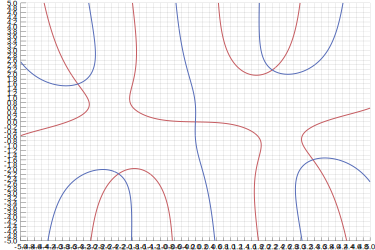

In [41]:
plot_level_curves(separatedDelta)

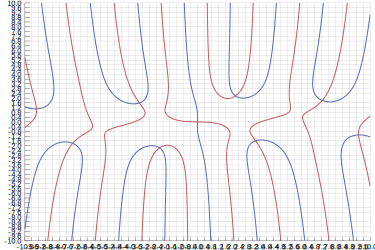

In [42]:
plot_level_curves(separatedDelta; xRange = (-10,10), yRange = (-10,10))

In [43]:
zeroList = [0+0*im, 2+im]

2-element Array{Complex{Int64},1}:
 0+0im
 2+1im

In [44]:
a = 1
f(x) = 1
q = solve_IBVP(L, U, pDerivMatrix, a, zeroList, infty, f)

2 + 1im
0 + 0im
gamma_a_+ = Complex{Float64}[3.536+3.536im, 0.167+0.167im, 0.236+0.0im, 5.0+0.0im]
gamma_a_- = Complex{Float64}[5.0+0.0im, 0.236+0.0im, 0.167-0.167im, 3.536-3.536im, -3.536-3.536im, -0.167-0.167im, -0.167+0.167im, -3.536+3.536im]
gamma_0_+ = Complex{Float64}[-0.118+0.0im, -0.083+0.083im, 0.0+0.118im, 0.083+0.083im, 0.118+0.0im, 0.083-0.083im, 0.0-0.118im, -0.083-0.083im, -0.118+0.0im]
gamma_0_- = Any[]


q (generic function with 1 method)

In [ ]:
q(1,1)

In [ ]:
x = linspace(0,2*pi,1000)
t = linspace(0,2*pi,1000)
Plots.contour(x, t, q, levels=[0], size = (1500, 1000), 
            tickfontsize = 20, seriescolor=:reds, transpose = false, linewidth = 4, linealpha = 1)